In [ ]:
import pandas as pd
import numpy as np
seed = np.random.seed(22)
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from preprocessing import *

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

#Librerías de métricas
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# haciendo los graficos un poco mas bonitos en matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

plt.rcParams['figure.dpi'] = 120

# seteando tipo de grid en seaborn
sns.set_theme(style='ticks', palette=None, font_scale=.9) 

In [ ]:
noticias_online_train_df = pd.read_parquet('train').set_index('url')

In [ ]:
noticias_online_test_df = pd.read_parquet('test').set_index('url')

In [ ]:
noticias_online_train_orden_df = noticias_online_train_df.sort_values('timedelta', ascending=False)
noticias_online_target_orden_df = noticias_online_train_orden_df.popular
noticias_online_train_orden_df = noticias_online_train_orden_df.drop(columns=['popular', 'shares'])

noticias_online_target_test_df = noticias_online_test_df.popular
noticias_online_test_df = noticias_online_test_df.drop(columns=['popular', 'shares'])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(noticias_online_train_orden_df, noticias_online_target_orden_df, 0.4)

# Knn imputer, robust scaler, one hot encoding y hashing encoding

## Encoders y preprocesado de X_train, X_val, Y_train e Y_val y train

In [ ]:
noticias_online_train_ht, noticias_online_val_ht, noticias_online_test_ht = preprocessing_knn_imputer_robust_escaler_one_hot_encoding_hashing_encoding(
    X_train, 
    X_val,
    noticias_online_test_df,
    True
)


noticias_online_train_target_enc = Y_train.map({False: 0, True: 1})
noticias_online_val_target_enc = Y_val.map({False: 0, True: 1})
noticias_online_target_test_enc = noticias_online_target_test_df.map({False: 0, True: 1})

## Búsqueda de hiperparámetros

In [ ]:
logistic_model = LogisticRegression(max_iter = 200, random_state=22)

penalty = ['l1', 'l2']
C = np.logspace(-4, 4, 50)
solver = ['newton-cg', 'lbfgs', 'liblinear']

logistic_hyperparameters = dict(penalty=penalty, C=C, solver=solver)

In [ ]:
rsearch = RandomizedSearchCV(estimator=logistic_model, param_distributions=logistic_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_iter=50, n_jobs=-1)
rsearch.fit(noticias_online_train_ht, noticias_online_train_target_enc)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=200, random_state=22),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.930...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='roc_auc', verbose=4)

In [ ]:
parametros = rsearch.best_params_
parametros

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.08685113737513521}

## Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = LogisticRegression(**parametros, random_state=22)
modelo.fit(noticias_online_train_ht, noticias_online_train_target_enc)

LogisticRegression(C=0.08685113737513521, penalty='l1', random_state=22,
                   solver='liblinear')

In [ ]:
prediccion = modelo.predict_proba(noticias_online_val_ht)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_val_target_enc, prediccion, average='micro'), 4)

0.7083

## Predicciones (uso test)

In [ ]:
prediccion = modelo.predict_proba(noticias_online_test_ht)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_target_test_enc, prediccion, average='micro'), 4)

0.7072

Genero el csv con las predicciones

In [ ]:
mi_prediccion = obtener_dataset_predicciones(noticias_online_test_df, noticias_online_target_test_df, prediccion)

In [ ]:
mi_prediccion.to_csv('baseline_knn_imputer_robust_escaler_one_hot_encoding_hashing_trick.csv')

## Plot features más relevantes

In [ ]:
peso_features = modelo.coef_[0]
features = noticias_online_train_ht.columns

aux = []
for i in range(len(peso_features)):
    aux.append((features[i], peso_features[i]))
    
features_relevantes = sorted(aux, key=lambda x: abs(x[1]), reverse=True)
top_10_features_relevantes = features_relevantes[:10]
valores = []
features = []
for elemento in top_10_features_relevantes:
    feature, valor = elemento
    features.append(feature)
    valores.append(valor)

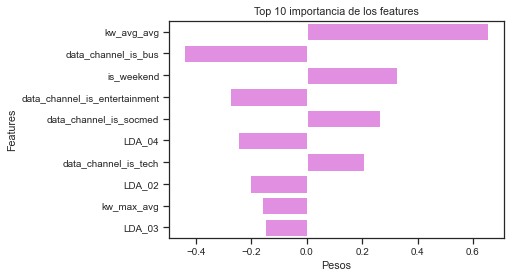

In [ ]:
plt.rcParams['figure.dpi'] = 120
sns.barplot(x=valores, y=features, color='violet')
plt.title('Top 10 importancia de los features')
plt.xlabel('Pesos')
plt.ylabel('Features')
plt.show()

# Mean imputer, standar scaler, one hot encoding y binary encoding

## Encoders y preprocesado de X_train, X_val, Y_train e Y_val y train

In [ ]:
noticias_online_train_bin, noticias_online_val_bin, noticias_online_test_bin = preprocessing_mean_imputer_standar_escaler_one_hot_encoding_binary_encoding(
    X_train, 
    X_val,
    noticias_online_test_df,
    True
)


noticias_online_train_target_enc = Y_train.map({False: 0, True: 1})
noticias_online_val_target_enc = Y_val.map({False: 0, True: 1})
noticias_online_target_test_enc = noticias_online_target_test_df.map({False: 0, True: 1})

## Búsqueda de hiperparámetros

In [ ]:
logistic_model = LogisticRegression(max_iter = 200, random_state=22)

penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
solver = ['newton-cg', 'lbfgs', 'liblinear']

logistic_hyperparameters = dict(penalty=penalty, C=C, solver=solver)

In [ ]:
rsearch = RandomizedSearchCV(estimator=logistic_model, param_distributions=logistic_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_iter=50, n_jobs=-1)
rsearch.fit(noticias_online_train_bin, noticias_online_train_target_enc)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=200, random_state=22),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='roc_auc', verbose=4)

In [ ]:
parametros = rsearch.best_params_
parametros

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}

## Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = LogisticRegression(**parametros, random_state=22)
modelo.fit(noticias_online_train_bin, noticias_online_train_target_enc)

LogisticRegression(C=0.01, random_state=22, solver='newton-cg')

In [ ]:
prediccion = modelo.predict_proba(noticias_online_val_bin)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_val_target_enc, prediccion, average='micro'), 4)

0.7036

## Predicciones (uso test)

In [ ]:
prediccion = modelo.predict_proba(noticias_online_test_bin)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_target_test_enc, prediccion, average='micro'), 4)

0.7051

Genero el csv con las predicciones

In [ ]:
mi_prediccion = obtener_dataset_predicciones(noticias_online_test_df, noticias_online_target_test_df, prediccion)

In [ ]:
mi_prediccion.to_csv('baseline_mean_imputer_standar_escaler_one_hot_encoding_binary_encoding.csv')

## Plot features más relevantes

In [ ]:
peso_features = modelo.coef_[0]
features = noticias_online_train_bin.columns

aux = []
for i in range(len(peso_features)):
    aux.append((features[i], peso_features[i]))
    
features_relevantes = sorted(aux, key=lambda x: abs(x[1]), reverse=True)
top_10_features_relevantes = features_relevantes[:10]
valores = []
features = []
for elemento in top_10_features_relevantes:
    feature, valor = elemento
    features.append(feature)
    valores.append(valor)

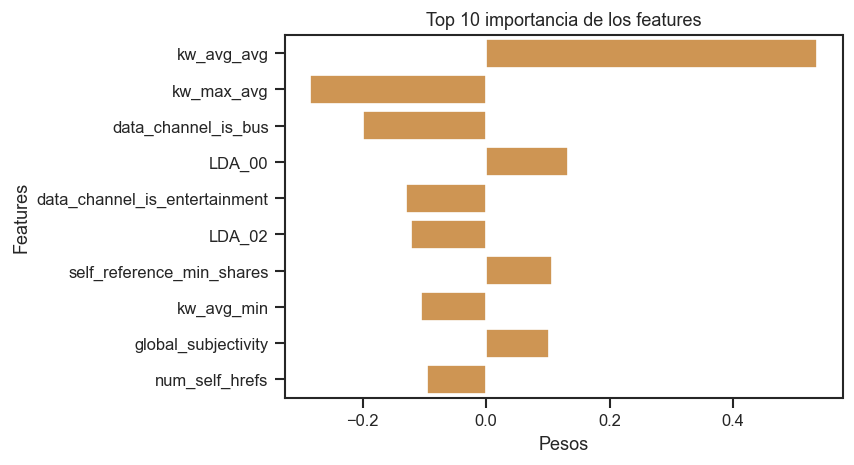

In [ ]:
plt.rcParams['figure.dpi'] = 120
sns.barplot(x=valores, y=features, color='#E3963E')
plt.title('Top 10 importancia de los features')
plt.xlabel('Pesos')
plt.ylabel('Features')
plt.show()